# Clustering of gan trained on human images

In [1]:
#@title Setup (may take a few minutes)
!git clone https://github.com/warmspringwinds/segmentation_in_style.git
import os
os.chdir(f'./segmentation_in_style')

import gdown, os

url = 'https://drive.google.com/uc?id=17dXYBWVEmaqnRddiV9eh8OqVoUTSn_0W'
output_path = 'human_ada.pth'
if not os.path.exists(output_path):
    gdown.download(url, output_path, quiet=False)



Cloning into 'segmentation_in_style'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 67 (delta 17), reused 35 (delta 5), pack-reused 0
Unpacking objects: 100% (67/67), done.


Downloading...
From: https://drive.google.com/uc?id=17dXYBWVEmaqnRddiV9eh8OqVoUTSn_0W
To: /content/segmentation_in_style/human_ada.pth
381MB [00:03, 98.7MB/s]


In [2]:
import torch.nn as nn
import skimage
from skimage.color import rgb2hsv
import numpy as np

import argparse
import math
import os

import torch
from torch import optim
from tqdm import tqdm

from models.stylegan2.model import Generator
import skimage.io as io

def norm_ip(img, min, max):
    img = img.clamp(min=min, max=max)
    img = img.add(-min).div(max - min + 1e-5)
    return img


g_ema = Generator(1024, 512, 8)

g_ema.load_state_dict(torch.load('human_ada.pth')["g_ema"], strict=True)
g_ema.eval()
g_ema = g_ema.cuda()
mean_latent = g_ema.mean_latent(4096)

truncation = 0.3

features = None
imgs = None

with torch.no_grad():

  for i in range(5):
    sample_z = torch.randn(10, 512).cuda()
    style = g_ema.style(sample_z)
    style = mean_latent + truncation * (style - mean_latent)

    img_gen, _, out = g_ema([style], input_is_latent=True, randomize_noise=False, feature_layer_number_to_return=7)

    import skimage.io as io

    def norm_ip(img, min, max):
        img = img.clamp(min=min, max=max)
        img = img.add(-min).div(max - min + 1e-5)
        return img

    #two = norm_ip(img_gen_2[0:1, :, :, :].cpu().detach().squeeze().permute(1, 2, 0), min=-1.0, max=1.0).numpy()
    one_input = nn.functional.upsample(img_gen,
                                      size=(128, 128),
                                      mode='bilinear',
                                      align_corners=True).clamp(min=-1.0, max=1.0).detach()
    print(out.shape)
    out = nn.functional.upsample(out,
                                 size=(128, 128),
                                 mode='bilinear',
                                 align_corners=True).detach()
    if imgs is None:
      imgs = one_input.cpu()
    else:
      aditional_imgs = one_input.cpu()
      imgs = torch.cat((imgs, aditional_imgs), axis=0)

    if features is None:
      features = out.cpu()
    else:
      additional_features = out.cpu()
      features = torch.cat((features, additional_features), axis=0)



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([10, 512, 64, 64])
torch.Size([10, 512, 64, 64])
torch.Size([10, 512, 64, 64])
torch.Size([10, 512, 64, 64])
torch.Size([10, 512, 64, 64])


In [3]:
features.shape

torch.Size([50, 512, 128, 128])

In [4]:
features_new = features.permute(0, 2, 3, 1).reshape(-1, 512)

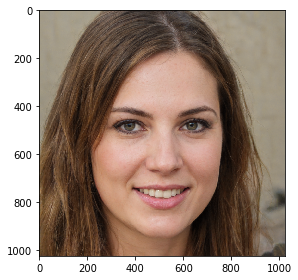

In [5]:
io.imshow(norm_ip(img_gen[1, :, :, :].permute(1, 2, 0), min=-1.0, max=1.0).cpu().numpy())

In [13]:
import numpy as np
from skimage import io
from sklearn.cluster import KMeans

n_colors = 10

arr = features_new.detach().cpu().numpy()#dist.detach().cpu().numpy().reshape(-1, 1)
kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(arr)

In [ ]:
features.shape

torch.Size([50, 512, 128, 128])

In [14]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [15]:
labels_spatial = labels.reshape(features.shape[0], features.shape[2], features.shape[3])

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


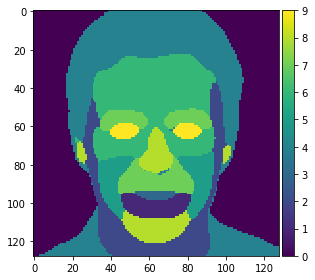

In [67]:
io.imshow(labels_spatial[43, :, :])

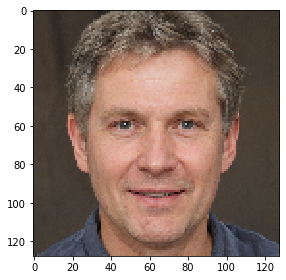

In [68]:
io.imshow(norm_ip(imgs[43, :, :, :], min=-1.0, max=1.0).permute(1, 2, 0).numpy())

In [69]:
import pickle

with open("k_means_human_7_layer_10_clusters.pkl", "wb") as f:
    pickle.dump(kmeans, f)